**Importamos las librerías a utilizar**

In [290]:
#Importamos libreria a usas
import numpy as np 
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json 
from geopy.geocoders import Nominatim
import requests 
from pandas.io.json import json_normalize 
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import matplotlib.pylab as plt
import folium 
print('Librerias importadas.')

Librerias importadas.


**Importando datos de Toronto de Wikipedia**


In [137]:
ruta = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
listar = pd.read_html(ruta)
df_toronto = listar[0]
import numpy as np
df_toronto['Borough'].replace('Not assigned',np.nan,inplace = True)
df_toronto.dropna(subset=['Borough'], axis = 0, inplace = True)
df_toronto.reset_index(inplace=True)
df_toronto.drop(columns = {'index'},inplace = True)
df_toronto.head()

,Postal Code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


**Aqui vamos a resolver el punto:**

Puede existir más de un vecindario en un área de código postal. 
Por ejemplo, en la tabla de la página de Wikipedia, notará que M5A aparece dos veces y tiene dos vecindarios: 
Harbourfront y Regent Park . Estas dos filas se combinarán en una fila con los barrios separados con una coma como se muestra en la fila 11 de la 
tabla anterior.

In [138]:
#Validamos si existen duplicados
df2 = df_toronto['Postal Code'].duplicated()
df2.value_counts()#Hay 103 resultados como False lo que indica que no hay duplicados

False    103
Name: Postal Code, dtype: int64

In [139]:
#Nos cercioramos de todos modos con el Cod Postal que ponen como ejemplo M5A
df2 = df_toronto[df_toronto['Postal Code']=='M5A']
df2 # Como se observa solo nos devuelve un registro

,Postal Code,Borough,Neighborhood
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"


**Si una celda tiene un distrito pero no un vecindario asignado , el vecindario será el mismo que el distrito.**

In [140]:
df_T = df_toronto[df_toronto['Neighborhood']=='Not assigned']
df_T #Vemos que no ay vencindarios como Not assigned

,Postal Code,Borough,Neighborhood


In [142]:
df_toronto.shape

(103, 3)

# **Cargamos el archivo CSV que contiene las coordenadas geográficas**

In [168]:
coor = '/home/Geospatial_Coordinates.csv'
df_coor = pd.read_csv(coor)
df_coor

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476
...,...,...,...
98,M9N,43.706876,-79.518188
99,M9P,43.696319,-79.532242
100,M9R,43.688905,-79.554724
101,M9V,43.739416,-79.588437


**Juntamos** los 2 DF

In [171]:
df_toronto_merge = df_toronto
df_toronto_merge = df_toronto_merge.join(df_coor.set_index('Postal Code'), on='Postal Code')
df_toronto_merge.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


Usamos geocode para saber las coordenadas de **Toronto**

In [172]:
address = 'Toronto'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('Coordenadas Geograficas {}, {}.'.format(latitude, longitude))

Coordenadas Geograficas 43.6534817, -79.3839347.


Unicamos en el mapa a Toronto y marcamos los **vencidarios**

In [196]:
mapa_toronto = folium.Map(location=[latitude,longitude], zoom_start=12)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_toronto_merge['Latitude'], df_toronto_merge['Longitude'], df_toronto_merge['Borough'], df_toronto_merge['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=7,
        popup=label,
        color='green',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7,
        parse_html=False).add_to(mapa_toronto)  
mapa_toronto

**Utilizaremos la API de Foursquare para explorar los vecindarios y segmentarlos.**

In [0]:
#Definimos credenciales
CLIENT_ID = ''
CLIENT_SECRET = ''
VERSION = '20180605'

**Creamos una funcion para obtener los 100 mejores lugares que se encuentran a 500 metros de cada barrio**

In [0]:
LIMIT = 500
def obtener_lugares(names, latitudes, longitudes, radius=500):
    
    lista_lugar=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # Creamos el API
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)
            
        # Realizamos la solicitud
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # Retornamos información relevante
        lista_lugar.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    df_lugares = pd.DataFrame([item for lista_lugar in lista_lugar for item in lista_lugar])
    df_lugares.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(df_lugares)

**Pasamos los parametros a la función para que nos devuelva el df con los lugares mas cercanos**

In [0]:
df_toronto_lugares = obtener_lugares(names=df_toronto_merge['Neighborhood'],
                                   latitudes=df_toronto_merge['Latitude'],
                                   longitudes=df_toronto_merge['Longitude'])

**Validamos cuantos datos tenemos y mostramos los 5 primeros registros**

In [216]:
print(df_toronto_lugares.shape)
df_toronto_lugares.head()

(2132, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,GTA Restoration,43.753396,-79.333477,Fireworks Store
2,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
3,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
4,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop


**Verificamos cuantos lugares nos devuelve por cada vecindario**

In [217]:
df_toronto_lugares.groupby('Neighborhood').count().head()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,5,5,5,5,5,5
"Alderwood, Long Branch",9,9,9,9,9,9
"Bathurst Manor, Wilson Heights, Downsview North",20,20,20,20,20,20
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",24,24,24,24,24,24


**Verificamos cuantas categorías unicas hay de todos los vecindarios**

In [210]:
print('Son {} caterías unicas.'.format(len(df_toronto_lugares['Venue Category'].unique())))

Son 280 caterías unicas.


# **Nos preparamos para analizar cada vencindario**

Convertimos las filas de las categorias en columnas para poder realizar el analisis

In [248]:
df_toronto_l = pd.get_dummies(df_toronto_lugares[['Venue Category']], prefix="", prefix_sep="")
#Agregamos la columna de vencidarios
df_toronto_l['Neighborhood'] = df_toronto_lugares['Neighborhood'] 
fixed_columns = [df_toronto_l.columns[-83]] + list(df_toronto_l.columns[:-83])
df_toronto_l = df_toronto_l[fixed_columns]
df_toronto_l.head()

,Neighborhood,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fireworks Store,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Housing Development,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Museum,Music Venue,Nail Salon
0,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

**Nuevo tamaño del data frame**

In [249]:
df_toronto_l.shape

(2132, 198)

Agrupamos las filas por vecindario y por la media de la concurrencia de los lugares

In [265]:
df_toronto_g = df_toronto_l.groupby('Neighborhood').mean().reset_index()
df_toronto_g.head()

,Neighborhood,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fireworks Store,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Housing Development,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Museum,Music Venue,Nail Salon
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.2,0.0,0.0,0.000000,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.

**Vemos el nuevo tamaño del df**

In [266]:
df_toronto_g.shape

(95, 198)

In [0]:
num_top_venues = 10

for hood in df_toronto_g['Neighborhood']:
    print("----"+hood+"----")
    temp = df_toronto_g[df_toronto_g['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

**Creamos una funcion para ordenar los lugares en forma descendente**

In [0]:
def return_most_common_venues(row, top_lugares):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:top_lugares]

**Creamos un nuevo marco de datos para visualizar los mjores 10 lugares por cada vencidario**


In [330]:
top_lugares = 10
indicators = ['st', 'nd', 'rd']

#Creamos columnas de acuerdo al top
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} mas comun'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th mas comun'.format(ind+1))

# create a new dataframe
df_toronto_top = pd.DataFrame(columns=columns)
df_toronto_top['Neighborhood'] = df_toronto_g['Neighborhood']

for ind in np.arange(df_toronto_g.shape[0]):
    df_toronto_top.iloc[ind, 1:] = return_most_common_venues(df_toronto_g.iloc[ind, :], top_lugares)

df_toronto_top.head()

,Neighborhood,1st mas comun,2nd mas comun,3rd mas comun,4th mas comun,5th mas comun,6th mas comun,7th mas comun,8th mas comun,9th mas comun,10th mas comun
0,Agincourt,Latin American Restaurant,Clothing Store,Lounge,Breakfast Spot,Comfort Food Restaurant,Colombian Restaurant,College Stadium,College Rec Center,College Gym,College Auditorium
1,"Alderwood, Long Branch",Coffee Shop,Athletics & Sports,Gym,Dance Studio,Nail Salon,Cocktail Bar,Comfort Food Restaurant,Colombian Restaurant,College Stadium,College Rec Center
2,"Bathurst Manor, Wilson Heights, Downsview North",Bank,Coffee Shop,Grocery Store,Mobile Phone Shop,Fried Chicken Joint,Ice Cream Shop,Deli / Bodega,Middle Eastern Restaurant,Bridal Shop,Gas Station
3,Bayview Village,Café,Bank,Chinese Restaurant,Japanese Restaurant,Nail Salon,Coffee Shop,Comfort Food Restaurant,Colombian Restaurant,College Stadium,College Rec Center
4,"Bedford Park, Lawrence Manor East",Italian Restaurant,Coffee Shop,Hobby Shop,American Restaurant,Indian Restaurant,Japanese Restaurant,Greek Restaurant,Grocery Store,Liquor Store,Comfort Food Restaurant


**Elimnamos la columna Neighborhood del df df_toronto_g, para crear el df df_toronto_cluster y ejecutar el modelo de cluster**

In [331]:
df_toronto_cluster = df_toronto_g.drop('Neighborhood', 1)
df_toronto_cluster.head()

,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fireworks Store,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Housing Development,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Museum,Music Venue,Nail Salon
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.2,0.0,0.0,0.000000,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,

**Hacemos uso de la grafica del Codo para saber la cantidad optima de cluster , usaremos 5 cluster**

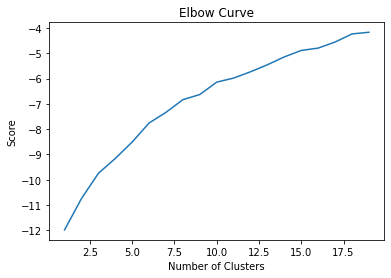

In [332]:
Nc = range(1,20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
score = [kmeans[i].fit(df_toronto_cluster).score(df_toronto_cluster) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

**Corremos el modelo**

In [333]:
kclusters = 10
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_toronto_cluster)
kmeans.labels_[0:10] 

array([6, 0, 0, 0, 0, 0, 0, 0, 6, 6], dtype=int32)

**Creemos un nuevo marco de datos que incluya el clúster y los 10 mejores lugares para cada vecindario**

In [0]:
#Agregamos al df df_toronto_top(que tiene el top10 de los mejores sitios) las etiquetas de cluster
df_toronto_top.insert(0, 'Cluster_Labels', kmeans.labels_)

In [335]:
#CReamos un nuevo dataframe y le pasamos el dataframe que contiene los datos del barrio y sus coordenadas
df_toronto_resultado = df_toronto_merge
df_toronto_resultado.head()
#Ahora juntamos los 2 df 
df_toronto_resultado = df_toronto_resultado.join(df_toronto_top.set_index('Neighborhood'), on='Neighborhood')

df_toronto_resultado.head() # check the last columns!

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster_Labels,1st mas comun,2nd mas comun,3rd mas comun,4th mas comun,5th mas comun,6th mas comun,7th mas comun,8th mas comun,9th mas comun,10th mas comun
0,M3A,North York,Parkwoods,43.753259,-79.329656,6.0,Food & Drink Shop,Fireworks Store,Nail Salon,Comfort Food Restaurant,Colombian Restaurant,College Stadium,College Rec Center,College Gym,College Auditorium,College Arts Building
1,M4A,North York,Victoria Village,43.725882,-79.315572,0.0,Grocery Store,Coffee Shop,Hockey Arena,Café,Cajun / Creole Restaurant,Comfort Food Restaurant,Colombian Restaurant,College Stadium,College Rec Center,College Gym
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0.0,Coffee Shop,Bakery,Café,Breakfast Spot,Event Space,Art Gallery,Beer Store,French Restaurant,Ice Cream Shop,Bank
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,6.0,Clothing Store,Furniture / Home Store,Event Space,Miscellaneous Shop,Boutique,Coffee Shop,Gift Shop,Accessories Store,Modern European Restaurant,Chocolate Shop
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,0.0,Coffee Shop,Beer Bar,Creperie,Bank,Bar,Arts & Crafts Store,Café,Gym,Mexican Restaurant,College Auditorium


**Finalmente visualizamos el resultado de los cluster**

In [340]:
map_clusters_t = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_toronto_resultado['Latitude'], df_toronto_resultado['Longitude'], df_toronto_resultado['Neighborhood'], df_toronto_resultado['Cluster_Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters_t)
       
map_clusters_t